In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
SEED = 12
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [2]:
# import pandas as pd

# # 기존 데이터 경로
# data_path = r"C:\Users\Yoon\OneDrive\한양대학교\3-2\시계열\Assignment\Project\DB\Final_1h_No Missing.csv"

# # 새로 포함할 Feature 목록
# selected_features = ['inner_temperature', 'outside_temperature', 'wind_speed', 'timestamp', 'cooling_power']

# # 데이터 로드
# df = pd.read_csv(data_path)

# # 선택된 Feature만 포함
# df_selected = df[selected_features]

# # 새로운 파일 저장 경로
# output_path = r"C:\Users\Yoon\OneDrive\한양대학교\3-2\시계열\Assignment\Project\DB\Selected_Features.csv"
# df_selected.to_csv(output_path, index=False)

# output_path


In [3]:
data_path = r"C:\Users\Yoon\OneDrive\한양대학교\3-2\시계열\Assignment\Project\DB\Clipped_CFS.csv"


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 데이터 경로 설정
data_path = r"C:\Users\Yoon\OneDrive\한양대학교\3-2\시계열\Assignment\Project\DB\Clipped_CFS.csv"

def load_data(path=data_path):
    """Loads the dataset, drops 'timestamp', and splits into X (features) and Y (target)."""
    df = pd.read_csv(path)
    df = df.drop(columns=['timestamp'])  # 'timestamp' 제거
    X = df.drop(columns=['cooling_power'])  # 입력 변수
    Y = df[['cooling_power']]  # 타겟 변수
    return X, Y



def split_data(X, Y, train_fraq, test_len=108):
    """Splits input X and target Y into train, val, and test sets."""
    if test_len > len(X):
        raise ValueError("test_len cannot be greater than the total number of samples.")
    
    test_slice = len(X) - test_len

    X_test, Y_test = X[test_slice:], Y[test_slice:]
    X_train_val, Y_train_val = X[:test_slice], Y[:test_slice]

    train_size = int(len(X_train_val) * train_fraq)

    X_train, Y_train = X_train_val[:train_size], Y_train_val[:train_size]
    X_val, Y_val = X_train_val[train_size:], Y_train_val[train_size:]

    return (X_train, Y_train), (X_val, Y_val), (X_test, Y_test)


def min_max_scale(train_X, train_Y, val_X, val_Y, test_X, test_Y):
    """Applies MinMax Scaling using only the Train data for fitting."""
    mm_X = MinMaxScaler()
    mm_Y = MinMaxScaler()

    # Fit on Train data only
    train_X_scaled = mm_X.fit_transform(train_X)
    train_Y_scaled = mm_Y.fit_transform(train_Y)

    # Transform Validation and Test data
    val_X_scaled = mm_X.transform(val_X)
    val_Y_scaled = mm_Y.transform(val_Y)
    test_X_scaled = mm_X.transform(test_X)
    test_Y_scaled = mm_Y.transform(test_Y)

    return (train_X_scaled, train_Y_scaled), (val_X_scaled, val_Y_scaled), (test_X_scaled, test_Y_scaled), mm_X, mm_Y


def window_dataset(X, Y, n_steps, n_horizon, batch_size, shuffle_buffer, for_training=True):
    """
    Creates a windowed TensorFlow dataset.
    
    Parameters:
    - X: Input features
    - Y: Target values
    - n_steps: Number of timesteps in input
    - n_horizon: Prediction horizon
    - batch_size: Batch size for the dataset
    - shuffle_buffer: Buffer size for shuffling (applies only for training)
    - for_training: If True, applies shuffling for training data
    
    Returns:
    - A TensorFlow dataset object.
    """
    # Sliding window generation
    ds_X = tf.data.Dataset.from_tensor_slices(X)
    ds_Y = tf.data.Dataset.from_tensor_slices(Y)

    # Apply window
    ds_X = ds_X.window(n_steps, shift=n_horizon, drop_remainder=True).flat_map(lambda x: x.batch(n_steps))
    ds_Y = ds_Y.window(n_horizon, shift=n_horizon, drop_remainder=True).flat_map(lambda x: x.batch(n_horizon))

    # Combine inputs and targets
    ds = tf.data.Dataset.zip((ds_X, ds_Y))

    # Apply shuffle only for training data
    if for_training:
        ds = ds.shuffle(shuffle_buffer)

    # Batch and prefetch
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [5]:
def lstm_model(n_steps, n_horizon, n_features, lr):
    """Creates an LSTM model for predicting a single target variable."""

    # Clear any previous session
    tf.keras.backend.clear_session()

    # Build the model
    model = tf.keras.models.Sequential([
        # First LSTM Layer
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        
        # Second LSTM Layer
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        
        # Dense Layers for Prediction
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),  # Dropout for regularization
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),  # Additional Dropout Layer
        
        # Output Layer (single value for n_horizon=1)
        tf.keras.layers.Dense(n_horizon)  # n_horizon=1 for single step prediction
    ], name='lstm')

    # Define loss and optimizer
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

    return model


In [6]:
X, Y = load_data()

# 데이터 분리
(train_X, train_Y), (val_X, val_Y), (test_X, test_Y) = split_data(X, Y, train_fraq=0.82, test_len=651)

# MinMax Scaling
(train_X_scaled, train_Y_scaled), (val_X_scaled, val_Y_scaled), (test_X_scaled, test_Y_scaled), mm_X, mm_Y = min_max_scale(
    train_X, train_Y, val_X, val_Y, test_X, test_Y
)

# TensorFlow Dataset 생성
train_ds = window_dataset(train_X_scaled, train_Y_scaled, n_steps=12, n_horizon=1, batch_size=32, shuffle_buffer=100, for_training=True)
val_ds = window_dataset(val_X_scaled, val_Y_scaled, n_steps=12, n_horizon=1, batch_size=32, shuffle_buffer=0, for_training=False)
test_ds = window_dataset(test_X_scaled, test_Y_scaled, n_steps=12, n_horizon=1, batch_size=32, shuffle_buffer=0, for_training=False)

In [7]:
# 스케일링 확인
print("Original train_Y range:", train_Y.min(), train_Y.max())
print("Scaled train_Y range:", train_Y_scaled.min(), train_Y_scaled.max())

# 복원 확인
train_Y_restored = mm_Y.inverse_transform(train_Y_scaled)
print("Restored train_Y range:", train_Y_restored.min(), train_Y_restored.max())


Original train_Y range: cooling_power    0.958901
dtype: float64 cooling_power    30.519911
dtype: float64
Scaled train_Y range: 0.0 0.9999999999999999
Restored train_Y range: 0.958901250000002 30.519911249999996


In [8]:
print("Original train_X range:", train_X.min(), train_X.max())
print("Scaled train_X range:", train_X_scaled.min(), train_X_scaled.max())

# 복원 확인
train_X_restored = mm_X.inverse_transform(train_X_scaled)
print("Restored train_X range:", train_X_restored.min(), train_X_restored.max())


Original train_X range: Wind_humidity_Interaction    19.440000
Temp_Difference             -17.574581
outside_temperature          26.910000
rainfall                      0.000000
inner_temperature            16.552301
dtype: float64 Wind_humidity_Interaction    603.436875
Temp_Difference                3.962500
outside_temperature           37.815000
rainfall                       0.000000
inner_temperature             37.164170
dtype: float64
Scaled train_X range: 0.0 1.0
Restored train_X range: -17.57458125 603.436875


In [9]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 설정
early_stopping = EarlyStopping(
    monitor='val_loss',       # Validation Loss를 모니터링
    patience=30,              # 개선되지 않는 에포크 수 (5번 기다림)
    restore_best_weights=True # 가장 낮은 Validation Loss에서의 가중치 복원
)


In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# # ReduceLROnPlateau 설정
lr_decay = ReduceLROnPlateau(
    monitor='val_loss',       # Validation Loss를 기준으로 Learning Rate 감소
    factor=0.8,               # Learning Rate를 50%로 줄임
    patience=15,               # 개선되지 않는 에포크 수 (5번 기다림)
    min_lr=1e-5               # Learning Rate의 하한값
)


In [11]:
model_checkpoint = ModelCheckpoint(
    filepath='clipped_best_lstm_cfs.keras',  # 저장 경로
    monitor='val_loss',       # 모니터링할 값
    save_best_only=True,      # Best 모델만 저장
    verbose=1
)

In [12]:
# LSTM 모델 생성
lstm = lstm_model(n_steps=12, n_horizon=1, n_features=train_X_scaled.shape[1], lr=3e-4)

# EarlyStopping 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Learning Rate Decay 콜백
lr_decay = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-5)

# 모델 학습
history = lstm.fit(
    train_ds,
    validation_data=val_ds,
    epochs=300,
    callbacks=[early_stopping, lr_decay, model_checkpoint]  # 콜백 추가
)

# # 테스트 결과 출력
# lstm.evaluate(test_ds)


Epoch 1/300


c:\Users\Yoon\.conda\envs\gpt\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


     87/Unknown 4s 6ms/step - loss: 0.1502 - mae: 0.4884

c:\Users\Yoon\.conda\envs\gpt\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.00443, saving model to clipped_best_lstm_cfs.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1431 - mae: 0.4711 - val_loss: 0.0044 - val_mae: 0.0721 - learning_rate: 3.0000e-04
Epoch 2/300
93/95 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0493 - mae: 0.2430
Epoch 2: val_loss improved from 0.00443 to 0.00269, saving model to clipped_best_lstm_cfs.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0485 - mae: 0.2406 - val_loss: 0.0027 - val_mae: 0.0589 - learning_rate: 3.0000e-04
Epoch 3/300
91/95 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0323 - mae: 0.1934
Epoch 3: val_loss improved from 0.00269 to 0.00175, saving model to clipped_best_lstm_cfs.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0315 - mae: 0.1905 - val_loss: 0.0018 - val_mae: 0.0474 - learning_rate: 3.0000e-04
Epoch 4/300
89/95 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0228 - mae: 0.1609
Epoch 4: val_loss improved from 0.00175 to 0.00146, saving model to clipped

In [13]:
# import tensorflow as tf

# # GPU 사용 가능한지 확인
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     print(f"사용 가능한 GPU: {gpus}")
# else:
#     print("GPU를 찾을 수 없습니다. CPU를 사용합니다.")

In [14]:
# !pip uninstall tensorflow
# !pip install tensorflow


In [15]:
# !pip install tensorflow-gpu==2.6.0

In [16]:
# !nvcc --version  # CUDA Toolkit 버전 확인


In [17]:
# 테스트 데이터셋에서 예측 수행
y_pred_scaled = lstm.predict(test_ds)  # (samples, n_horizon) 형태

# y_pred를 (samples, 1)로 변환
y_pred = y_pred_scaled.reshape(-1, 1)  # 2차원으로 변환

# y_pred의 스케일 복원
y_pred = mm_Y.inverse_transform(y_pred)

# y_true를 TensorFlow Dataset에서 추출 및 스케일 복원
y_true_scaled = np.concatenate([y for x, y in test_ds], axis=0)  # (samples, n_horizon)
y_true = y_true_scaled.reshape(-1, 1)  # 2차원으로 변환
y_true = mm_Y.inverse_transform(y_true)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE (Mean Absolute Error)
mae = mean_absolute_error(y_true, y_pred)

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 성능 결과 출력
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 1.09
RMSE: 1.40
MAPE: 9.17%


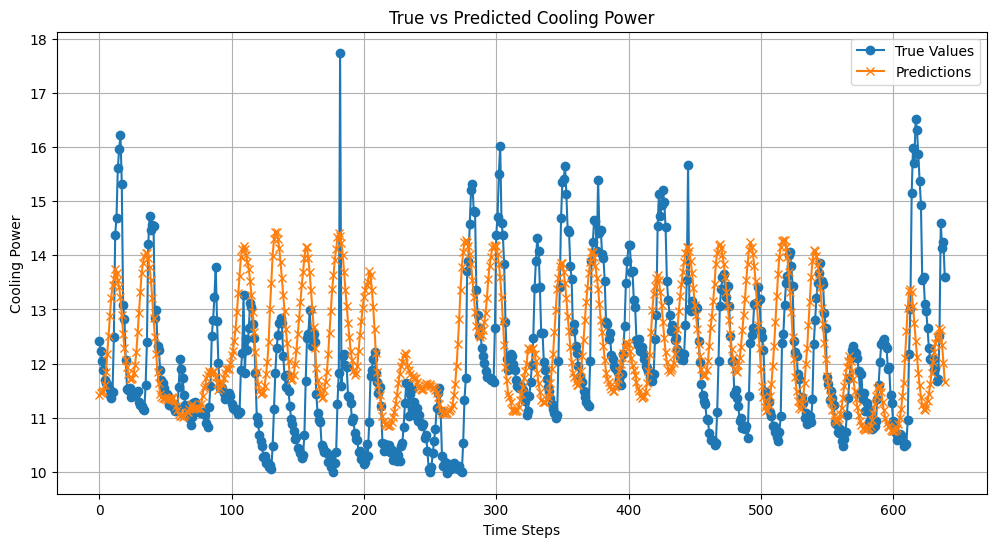

In [19]:
import matplotlib.pyplot as plt

# 샘플 수 선택 (테스트 데이터 일부만 시각화)

plt.figure(figsize=(12, 6))

plt.plot(y_true, label="True Values", marker='o')
plt.plot(y_pred, label="Predictions", marker='x')

plt.title("True vs Predicted Cooling Power")
plt.xlabel("Time Steps")
plt.ylabel("Cooling Power")
plt.legend()
plt.grid()
plt.show()


In [20]:
class PositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, embed_dim):
        super().__init__()
        self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_len, output_dim=embed_dim)

    def call(self, inputs):
        positions = tf.range(start=0, limit=tf.shape(inputs)[1], delta=1)
        positions = self.pos_embedding(positions)
        return inputs + positions


In [21]:
def transformer_model(n_steps, n_horizon, n_features, lr):
    """Creates an optimized Transformer model for time series forecasting."""

    # Clear any previous session
    tf.keras.backend.clear_session()

    # Input Layer
    inputs = tf.keras.layers.Input(shape=(n_steps, n_features))

    # Position Embedding
    position_embedding = PositionEmbedding(max_len=n_steps, embed_dim=n_features)(inputs)

    # Transformer Encoder
    transformer = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=64)(position_embedding, position_embedding)
    transformer = tf.keras.layers.LayerNormalization(epsilon=1e-6)(transformer)
    transformer = tf.keras.layers.Dropout(0.1)(transformer)

    # Feed-Forward Network
    ff = tf.keras.layers.Dense(128, activation="relu")(transformer)
    ff = tf.keras.layers.Dropout(0.1)(ff)
    ff = tf.keras.layers.Dense(64, activation="relu")(ff)
    ff = tf.keras.layers.LayerNormalization(epsilon=1e-6)(ff)

    # Global Average Pooling
    pooled = tf.keras.layers.GlobalAveragePooling1D()(ff)

    # Output Layer
    outputs = tf.keras.layers.Dense(n_horizon)(pooled)

    # Build Model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="transformer")

    # Custom Learning Rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=1000,
        decay_rate=0.96,
        staircase=True
    )

    # Compile Model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss="mse",
                  metrics=["mae"])

    return model


In [22]:
# EarlyStopping 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)


In [23]:
model_checkpoint = ModelCheckpoint(
    filepath='clipped_best_transformer_cfs.keras',  # 저장 경로
    monitor='val_loss',       # 모니터링할 값
    save_best_only=True,      # Best 모델만 저장
    verbose=1
)

In [24]:
# LSTM 모델 생성
transformer = transformer_model(n_steps=12, n_horizon=1, n_features=train_X_scaled.shape[1], lr=3e-4)

# EarlyStopping 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Learning Rate Decay 콜백
lr_decay = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-5)

# 모델 학습
history_transformer = transformer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
      callbacks=[early_stopping,model_checkpoint]  # 콜백 추가
)

Epoch 1/100
     94/Unknown 3s 5ms/step - loss: 0.1825 - mae: 0.2756

c:\Users\Yoon\.conda\envs\gpt\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.00609, saving model to clipped_best_transformer_cfs.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1801 - mae: 0.2734 - val_loss: 0.0061 - val_mae: 0.0619
Epoch 2/100
85/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0301 - mae: 0.1402
Epoch 2: val_loss improved from 0.00609 to 0.00416, saving model to clipped_best_transformer_cfs.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0294 - mae: 0.1381 - val_loss: 0.0042 - val_mae: 0.0493
Epoch 3/100
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0228 - mae: 0.1192
Epoch 3: val_loss improved from 0.00416 to 0.00364, saving model to clipped_best_transformer_cfs.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0227 - mae: 0.1190 - val_loss: 0.0036 - val_mae: 0.0474
Epoch 4/100
86/95 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0199 - mae: 0.1101
Epoch 4: val_loss did not improve from 0.00364
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0195 - mae: 0.1088 - val_loss: 0.0056 - val

In [25]:
# 테스트 데이터셋에서 예측 수행
y_pred_scaled = transformer.predict(test_ds)  # (samples, n_horizon) 형태

# y_pred를 (samples, 1)로 변환
y_pred = y_pred_scaled.reshape(-1, 1)  # 2차원으로 변환

# y_pred의 스케일 복원
y_pred = mm_Y.inverse_transform(y_pred)

# y_true를 TensorFlow Dataset에서 추출 및 스케일 복원
y_true_scaled = np.concatenate([y for x, y in test_ds], axis=0)  # (samples, n_horizon)
y_true = y_true_scaled.reshape(-1, 1)  # 2차원으로 변환
y_true = mm_Y.inverse_transform(y_true)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [26]:

# 성능 평가
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE (Mean Absolute Error)
mae = mean_absolute_error(y_true, y_pred)

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 성능 결과 출력
print(f"Transformer Results")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


Transformer Results
MAE: 0.72
RMSE: 0.95
MAPE: 5.83%


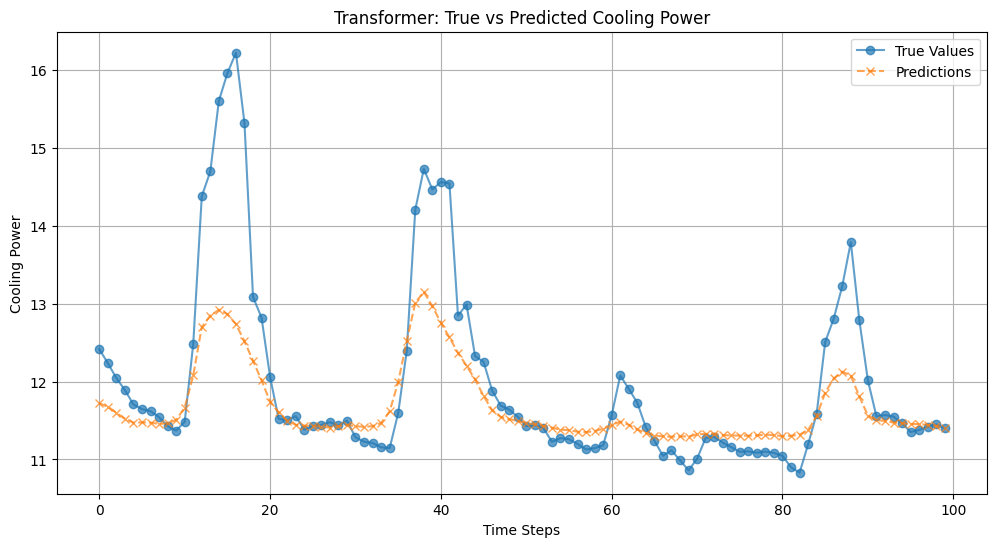

In [27]:

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# 샘플 수 선택 (테스트 데이터 일부만 시각화)
plt.plot(y_true[:100], label="True Values", marker='o', linestyle='-', alpha=0.7)
plt.plot(y_pred[:100], label="Predictions", marker='x', linestyle='--', alpha=0.7)

plt.title("Transformer: True vs Predicted Cooling Power")
plt.xlabel("Time Steps")
plt.ylabel("Cooling Power")
plt.legend()
plt.grid()
plt.show()
